In [1]:
import sys
# !{sys.executable} -m pip install shap
import lightgbm as lgb
import xgboost
import shap
from xgboost import XGBRegressor
from collections import Counter

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Torch
import torch
print(torch.__version__,torch.__path__)
import torch.nn as nn

# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, MACCSkeys
from openbabel import openbabel as ob
from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
from plotly.offline import offline
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


2.1.0 ['/Users/voglab04/miniconda3/envs/molecular_representation/lib/python3.8/site-packages/torch']
Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 0

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
df=pd.read_excel('site_data.xlsx',index_col=0)
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_link','B_link', 'A_side', 'B_side']
inter_df=df[sitelist].dropna()
# inter_df[inter_df!=0]=1

In [3]:


y=pd.read_excel('400_dipeptides_interaction_energy.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","").replace('acid','')) for i in pd.read_excel('400_dipeptides_interaction_energy.xlsx', 'Sheet2',header=None).values]).set_index(0)


# Find set of files
monomerfiles={}        
co2files={}
for k,v in pairs.to_dict()[1].items():
    try:
        path=glob(f'./dipeptides_co2_coordinates/{k}_*.xyz')[0]
        monpath=f'./dipeptides_coordinates/{k}.xyz'
        if os.path.exists(path) and os.path.exists(monpath):
            co2files[v]=path    
            monomerfiles[v]=monpath
    except:
        print(k)
        
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files.values()]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles.values()]

In [4]:
# pixelsx = 150 # Don't make too large 150
# pixelsy = 150 # 150
pixelsx = 20 # Don't make too large 150
pixelsy = pixelsx # 150
spread = 0.06
Max = 2.5 # 2.5
X=np.zeros((len(monomerfiles),pixelsx**2))
for i,(k,v) in enumerate(monomerfiles.items()):
     X[i,:] = VariancePersistv1(v, pixelx=pixelsx, pixely=pixelsy,myspread=spread, myspecs={"maxBD": Max, "minBD":  -0.1}, showplot=False)
    

In [5]:
VariancePersist

<function Element_PI.VariancePersist(Filename, pixelx=100, pixely=100, myspread=2, myspecs={'maxBD': 2, 'minBD': 0}, showplot=True)>

In [6]:
AAs=sorted(set([i[0].split('-')[0].replace('acid','') for i in pairs.values]))

In [7]:
noncarboyx=inter_df[(inter_df[['A_carboxy','B_carboxy']]==0).all(axis=1)]

In [8]:
noncarboyx

,A_carboxy,A_amine,B_carboxy,B_amine,A_link,B_link,A_side,B_side
Alanine-Lysine,0,0,0,1,0,0,0,2
Arginine-Aspartic,0,0,0,0,0,0,0,3
Arginine-Cysteine,0,0,0,0,0,0,3,0
Arginine-Lysine,0,0,0,0,0,0,3,0
Arginine-Phenylalanine,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
Tryptophan-Proline,0,0,0,0,0,0,3,0
Tryptophan-Tryptophan,0,0,0,0,0,0,0,3
Tyrosine-Arginine,0,0,0,2,0,0,0,1
Tyrosine-Lysine,0,1,0,0,0,0,0,2


In [9]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2files.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    


In [10]:
# FLAG!
# df.loc['Asparagine-Alanine']
# fig = to_plotly_figure(co2mgs['Asparagine-Alanine'])
# offline.plot(fig)

# FLAG THIS ONE!!
# fig = to_plotly_figure(co2mgs['Alanine-Lysine'])
# offline.plot(fig)

In [11]:
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    for j in names:
        if 'acid' in j:
            print(names)

In [12]:
AAs

['Alanine',
 'Arginine',
 'Asparagine',
 'Aspartic',
 'Cysteine',
 'Glutamic',
 'Glutamine',
 'Glycine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Lysine',
 'Methionine',
 'Phenylalanine',
 'Proline',
 'Serine',
 'Threonine',
 'Tryptophan',
 'Tyrosine',
 'Valine']

In [54]:
# tsne = TSNE(n_components=2, verbose=1, perplexity=399, n_iter=500)
# tsne_results = tsne.fit_transform(X)
# pcadf=pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
# pcadf['tsne-2d-one'] = tsne_results[:,0]
# pcadf['tsne-2d-two'] = tsne_results[:,1]
# pcadf.index=df.index
# pcadf['Interaction_Energy']=df['Interaction_Energy'].astype(int)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue='Interaction_Energy',
#     palette=sns.color_palette("hls", 8),
#     data=pcadf,
#     legend="full"
# )

In [57]:
# pca = PCA(n_components=3)
# pca_result = pca.fit_transform(X)

# pcadf['pca-one'] = pca_result[:,0]
# pcadf['pca-two'] = pca_result[:,1] 
# pcadf['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print(sum(pca.explained_variance_ratio_))
# plt.figure(figsize=(16,10))
# # sns.scatterplot(
# #     x="pca-one", y="pca-two",
# #     hue='Interaction_Energy',
# #     palette=sns.color_palette("hls", 8),
# #     data=pcadf,
# #     legend="full"
# # )

# # sns.scatterplot(
# #     x="pca-one", y="pca-three",
# #     hue='Interaction_Energy',
# #     palette=sns.color_palette("hls", 8),
# #     data=pcadf,
# #     legend="full"
# # )


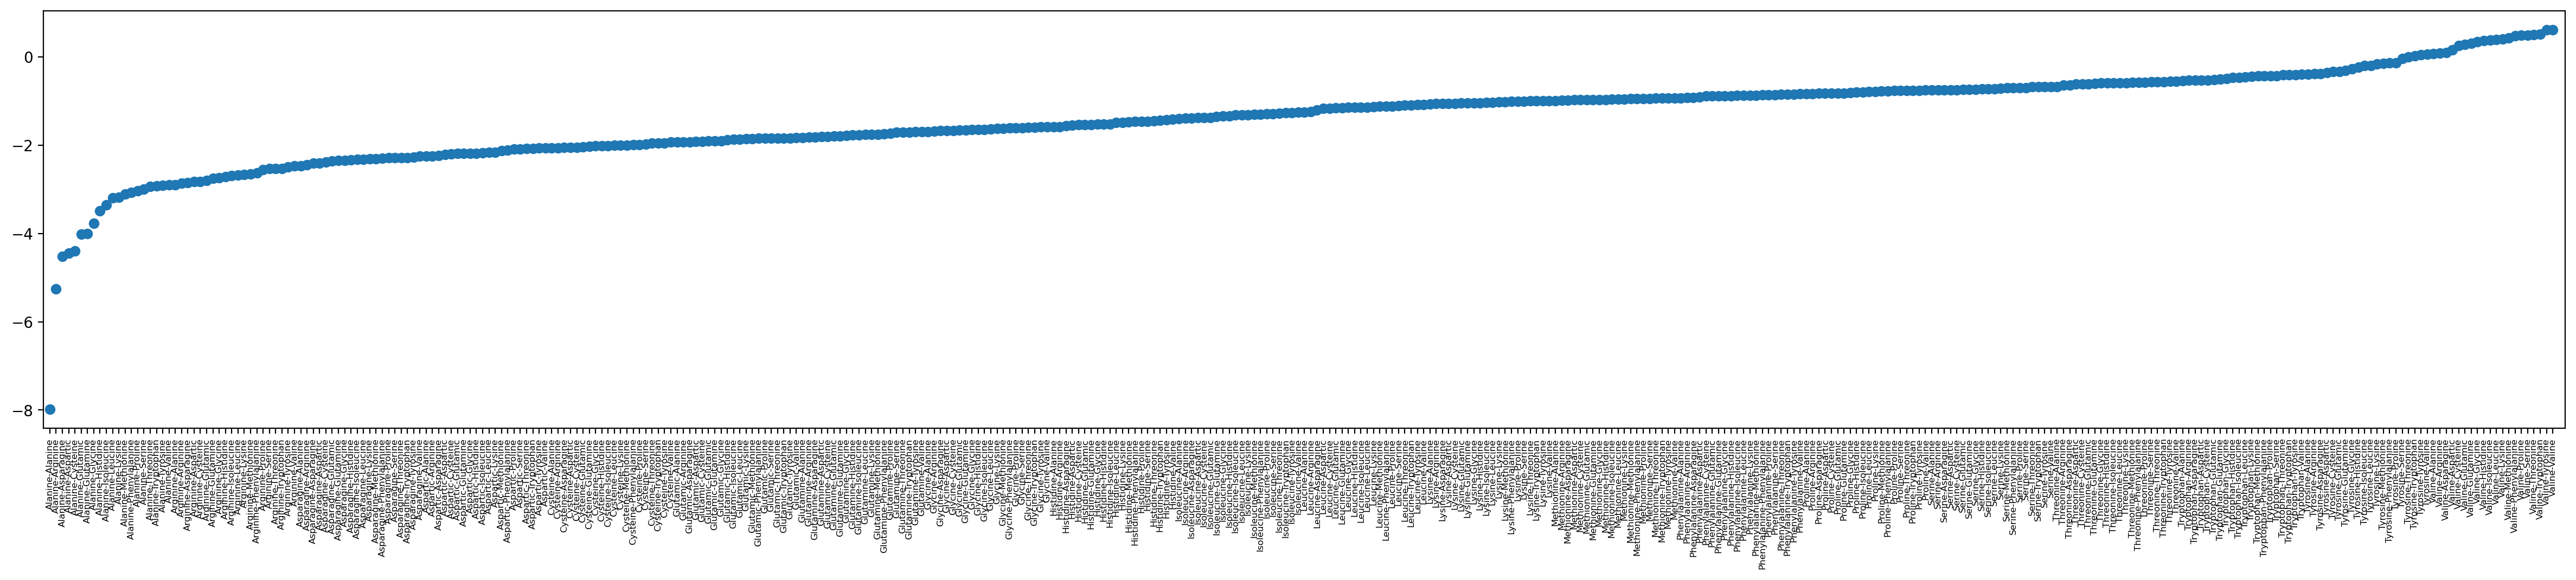

In [58]:
plt.figure(figsize=(30,5))
plt.scatter(range(len(df['Interaction_Energy'])),(df['Interaction_Energy']-df['Interaction_Energy']['Glycine-Glycine']).sort_values())
plt.xticks(range(len(df['Interaction_Energy'])),df['Interaction_Energy'].index,rotation=90, fontsize = 6)
plt.xlim(-1,len(df['Interaction_Energy'])+1)
plt.show()

In [ ]:
# samples=len(y)
# X=np.zeros((samples,len(AAs)))
# Y=np.zeros((samples,1))

# for idx,(k,v) in enumerate(y.set_index('keypair').to_dict()['Interaction_Energy'].items()):
#     aa=pairs.loc[k].values[0].split('-')
#     a1=aa[0]
#     a2=aa[1]
#     if a1!=a2:
#         X[idx,bitkey[a1]]=1
#         X[idx,bitkey[a2]]=1
#     else:
#         X[idx,bitkey[a1]]=2
#     Y[idx]=v

In [72]:
X
y=df['Interaction_Energy'].values
X_train,X_test,y_train, y_yest=train_test_split(X,y,test_size=0.3)

In [74]:

model=XGBRegressor().fit(X_train,y_train)

In [76]:
model.score(X_train,y_train),model.score(X_test,y_yest)

(0.9999979250106392, 0.12018454536562939)

In [ ]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [ ]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [ ]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [ ]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))